# RNA Velocity

In [2]:
import loompy
import scvelo as scv
#scv.logging.print_version(), not running this line seems to avoid the dead kernel at the pp.neigbors step

In [3]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization


### Load the Data

In [4]:
ldata = scv.read('Loom_files/all_merged.loom', cache=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata = scv.read('write/Ingest_all_small.h5ad', cache=True)

In [6]:
import scanpy as sc
import pandas as pd
from matplotlib import rcParams


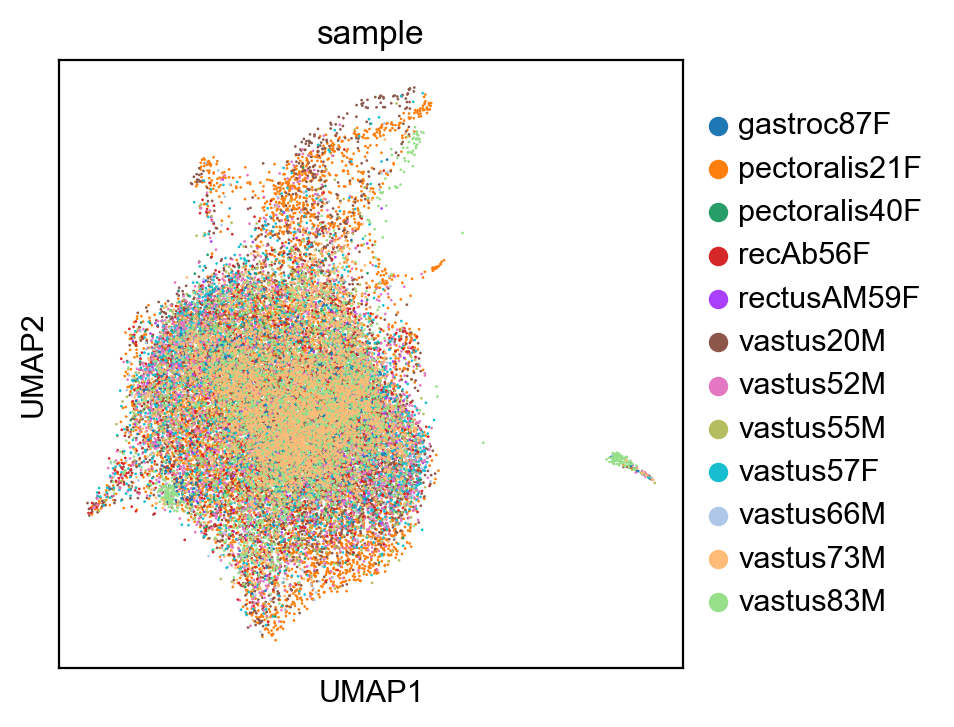

In [7]:
rcParams['figure.figsize'] = 4, 4
sc.pl.umap(adata, color='sample')

In [8]:
adata = scv.utils.merge(adata, ldata)
adata

AnnData object with n_obs × n_vars = 31807 × 97
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'age', 'muscle', 'sample', 'batch', 'cell type', 'umap_density_batch', 'sample_batch', 'TotalUMIs', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'mt', 'highly_variable', 'n_cells-0-1_Young', 'n_cells_by_counts-0-1_Young', 'mean_counts-0-1_Young', 'pct_dropout_by_counts-0-1_Young', 'total_counts-0-1_Young', 'means-0-1_Young', 'dispersions-0-1_Young', 'dispersions_norm-0-1_Young', 'mean-0-1_Young', 'std-0-1_Young', 'n_cells-1-1_Young', 'n_cells_by_counts-1-1_Young', 'mean_counts-1-1_Young', 'pct_dropout_by_counts-1-1_Young', 'total_counts-1-1_Young', 'means-1-1_Young', 'dispersions-1-1_Young', 'dispersions_norm-1-1_Young', 'mean-1-1_Young', 'std-1-1_Young', 'n_cells-0-2_Adult', 'n_cells_by_counts-0-2_Adult', 'mean_counts-0-2_Adult', 'pct_dropout_by_counts-0-2_Adult', 'total_counts-0

### Preprocess the Data

In [10]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:17) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Estimate RNA velocity

In [11]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [12]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Project the velocities

computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


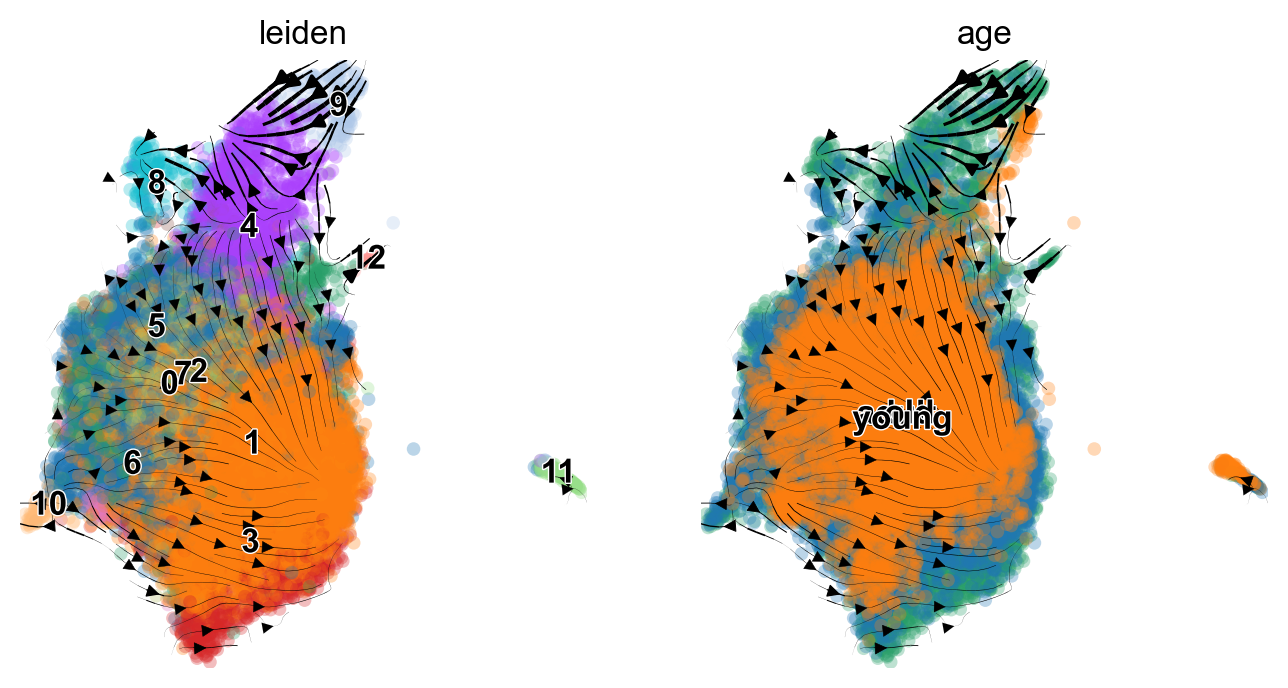

In [13]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color= ['leiden', 'age'])


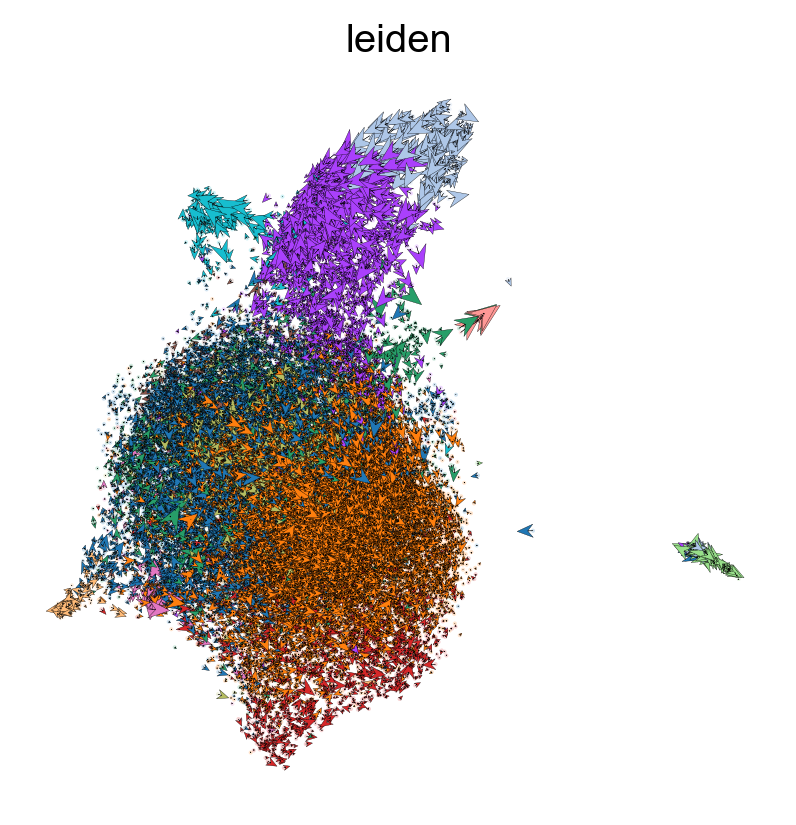

In [45]:
scv.pl.velocity_embedding(adata, arrow_length=10, arrow_size=10, dpi=120, color='leiden')


In [17]:
#subset hu-MuSCs
adata_subset = adata[adata.obs['leiden'].isin(['0', '1', '2', '3', '5', '6', '7', '10'])]

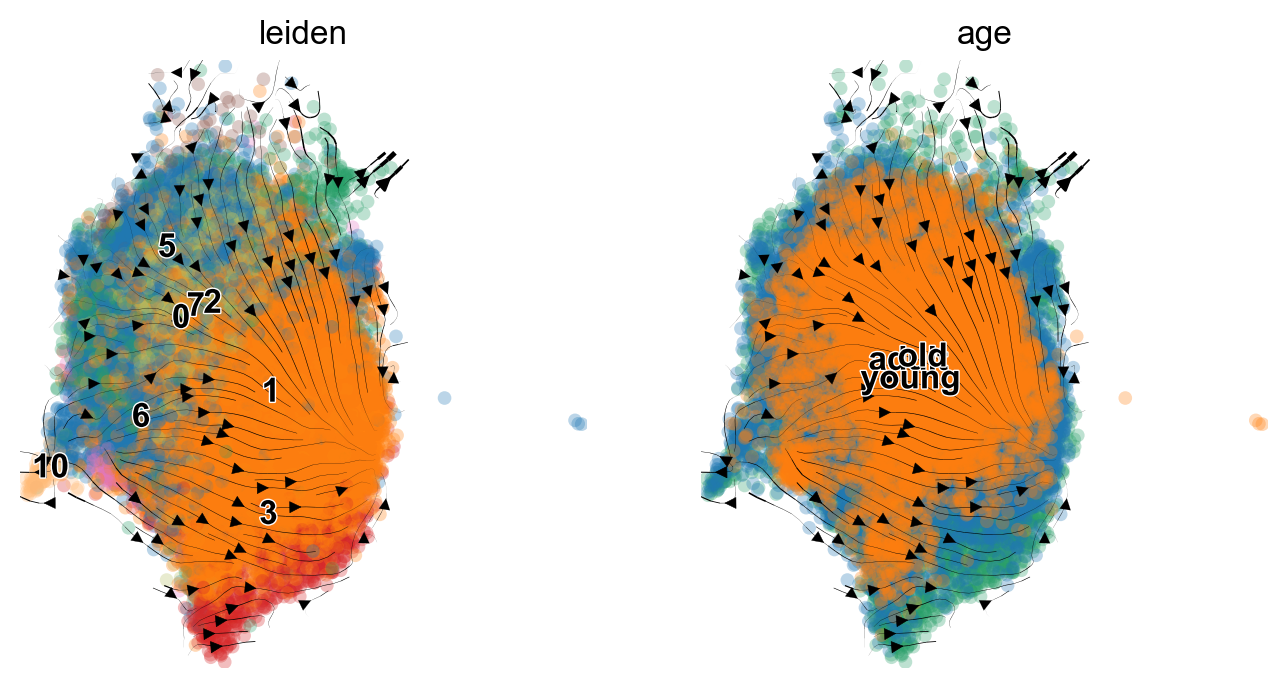

In [18]:
scv.pl.velocity_embedding_stream(adata_subset, basis='umap', color= ['leiden', 'age'])

### Interprete the velocities

saving figure to file ./figures/scvelo_all_extragene_velocity.pdf


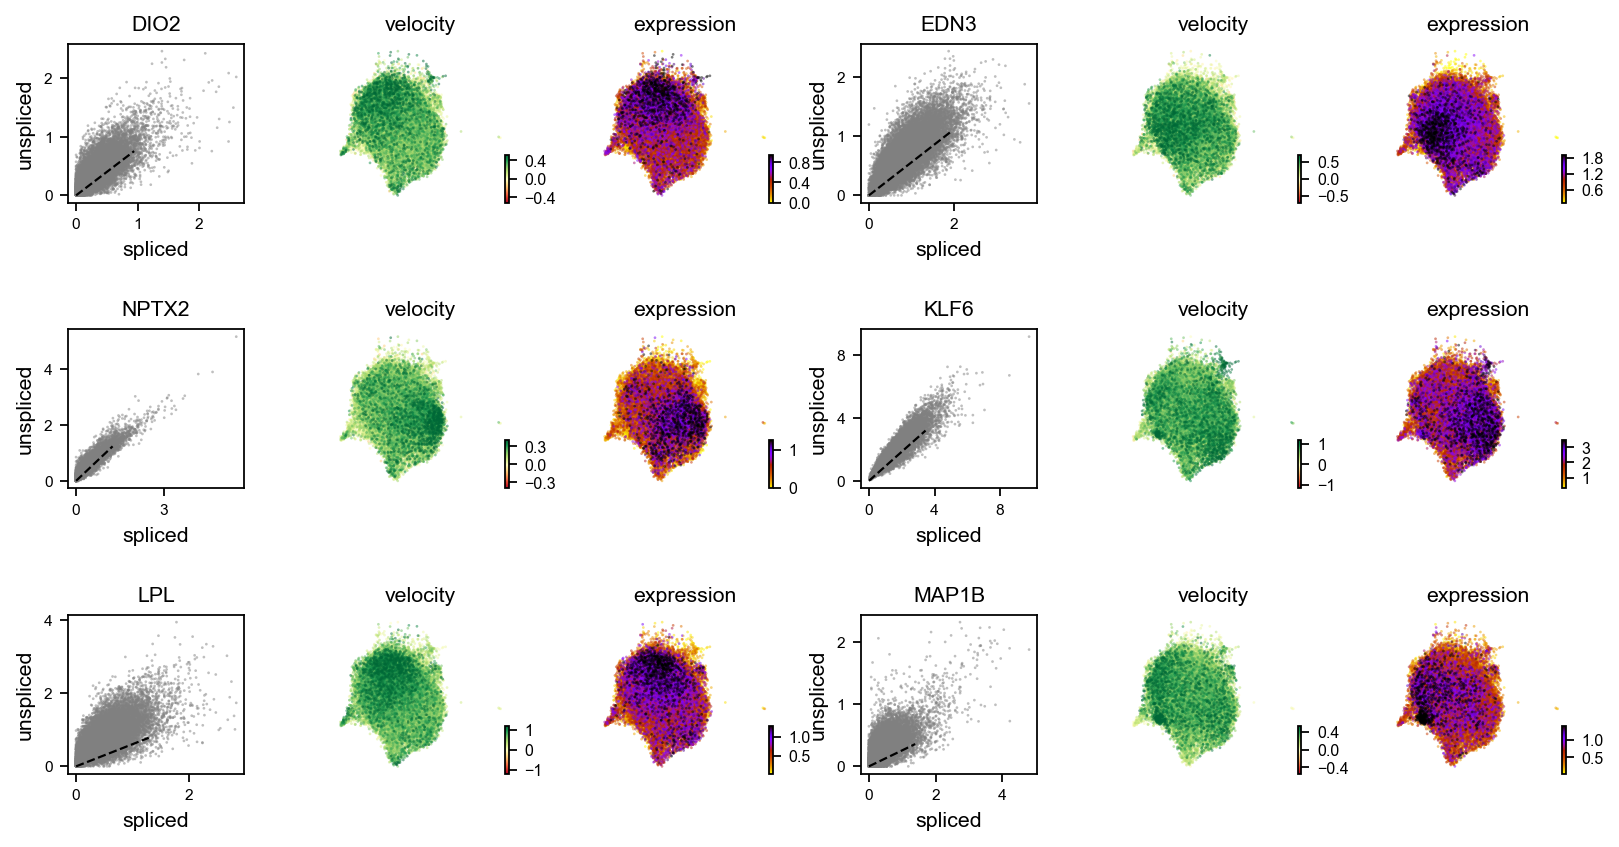

In [70]:
scv.pl.velocity(adata_subset, ['DIO2', 'EDN3','NPTX2', 'KLF6', 'LPL', 'MAP1B'], ncols=2, dpi=300, save='all_extragene_velocity.pdf')

saving figure to file ./figures/scvelo_all_gene_velocity.pdf


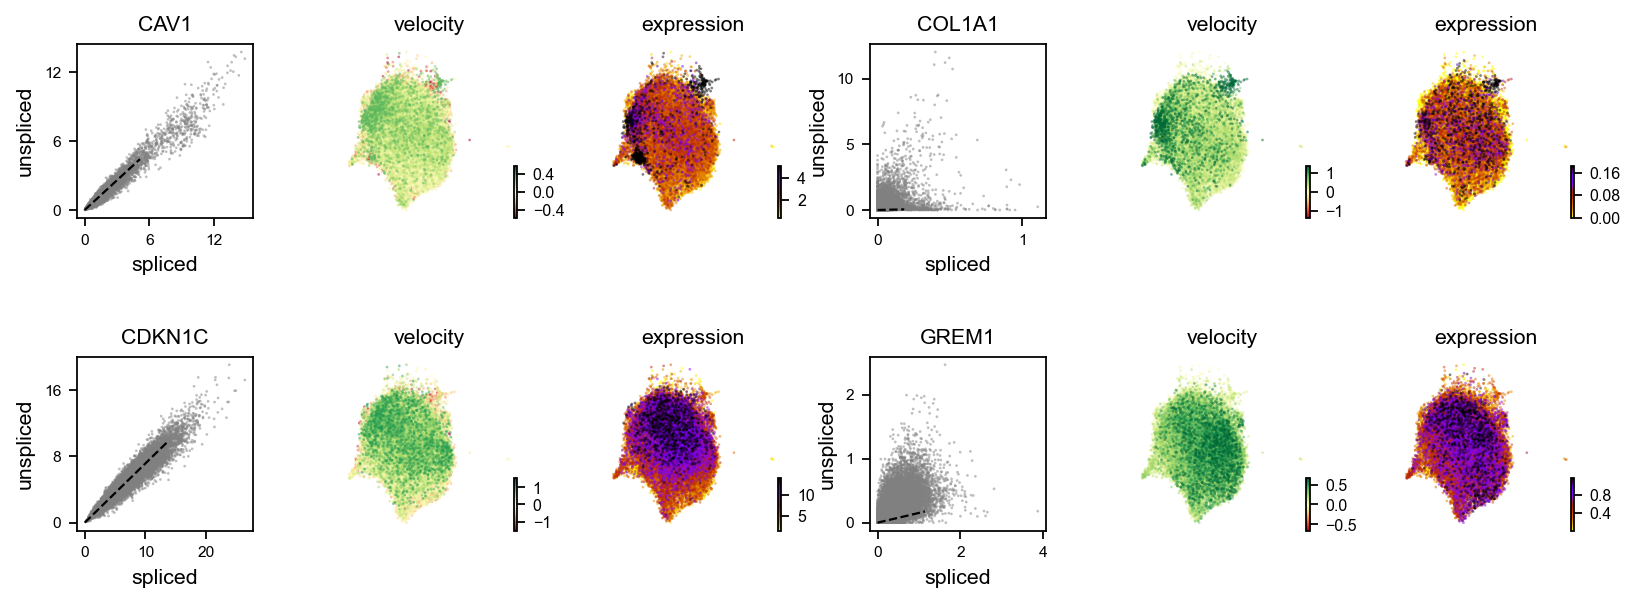

In [54]:
scv.pl.velocity(adata_subset, ['CAV1', 'COL1A1', 'CDKN1C', 'GREM1'], ncols=2, dpi=300, save='all_gene_velocity.pdf')

The black line corresponds to the estimated 'steady-state' ratio, i.e. the ratio of unspliced to spliced mRNA abundance which is in a constant transcriptional state. RNA velocity for a particular gene is determined as the residual, i.e. how much an observation deviates from that steady-state line. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

### Identify important genes
We need a systematic way to identify genes that may help explain the resulting vector field and inferred lineages. 
To do so, we can test which genes have cluster-specific differential velocity expression, being siginificantly higher/lower compared to the remaining population. The module `scv.tl.rank_velocity_genes` runs a differential velocity t-test and outpus a gene ranking for each cluster. Thresholds can be set (e.g. `min_corr`) to restrict the test on a selection of gene candidates.

In [20]:
scv.tl.rank_velocity_genes(adata_subset, groupby='age', min_corr=.3)

df = scv.DataFrame(adata_subset.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes


Trying to set attribute `.var` of view, copying.


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,adult,old,young
0,CDKN1C,CRYAB,LPL
1,CRYAB,HBEGF,TPM1
2,NPTX2,DNAJB1,DIO2
3,CAV1,GREM1,ADAMTS8
4,TMSB4X,CDKN1C,COL1A1


In [22]:
df.to_csv('velocity_age_all.csv')